Code Created by Florent Poux. 
This is part of a joint work with:
* Prof. Sander Oude Elberink, 
* Prof. Mila Koeva, 
* Prof. Ville Lehtola, 
* Prof. Nourian Pirouz, 
* Prof. Paulo Raposo.

Licence MIT, worked done with UTWENTE. Please refer to the article for the full comprehension.

Members of the [ITC UTWENTE](https://www.itc.nl/) or students enrolled in a Program can use the code with privileged IP Rights. 

*   Have fun with this notebook that you can very simply run (ctrl+Enter) !
*   Make sure to modify the paths to your dataset, either locally stored, on the CRIB, or in your Drive.
*   You are free to reuse in your own project, please use the followinf reference if so: XXX

For assistance:  [Linkedin](https://www.linkedin.com/in/florent-poux-point-cloud/), [Medium](https://medium.com/@florentpoux) or [Twitter](https://twitter.com/PouxPointCloud).

Enjoy!

# Step 3: Python Automation

# 3.1. Importing libraries

In [1]:
#Base libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#3D Libraries
import open3d as o3d
import laspy
print(laspy.__version__)

#Geospatial libraries
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon


print(f"Open 3D Version: {o3d.__version__}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3
Open 3D Version: 0.18.0


# 3.2. Loading 3D datasets

We define the specific paths to our dataset:

In [2]:
data_folder="../DATA/"
pc_dataset="28GN1_08_sampled.xyz"
mesh_dataset="pijlkruid_bag.ply"
glb_dataset="pijlkruid.glb" # model.glb
result_folder="../DATA/RESULTS/"

We can prepare the point cloud by first creating a Pandas DataFrame object called pcd_df, which will host the point cloud data:

In [3]:
pcd_df= pd.read_csv(data_folder+pc_dataset, delimiter=";")
print(pcd_df.columns)

Index(['X', 'Y', 'Z', 'R', 'G', 'B', 'Intensity', 'Return Number',
       'Number Of Returns', 'Scan Direction Flag', 'EdgeOfFlightLine',
       'Classification', 'Scan Angle', 'User Data', 'Point Source ID',
       'Gps Time', 'Near Infrared', 'Deviation', 'Withheld', 'Synthetic',
       'KeyPoint', 'Overlap', 'Amplitude', 'Reflectance'],
      dtype='object')


Numpy to Open3D

In [4]:
pcd_o3d=o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(pcd_df[['X','Y','Z']])))
pcd_o3d.colors=o3d.utility.Vector3dVector(np.array(pcd_df[['R','G','B']])/255)
pcd_o3d

PointCloud with 5145352 points.

Loading the Mesh dataset

In [5]:
mesh=o3d.io.read_triangle_mesh(data_folder+mesh_dataset)
mesh.paint_uniform_color([0.9,0.9,0.9])

TriangleMesh with 105 points and 198 triangles.

# 3.3. Python 3D Visualization

To vizualise in Open3D in the specific viewer, all we have to do is to pass a python list of objects to visualize. Our list is thus composed of one Open3D PointCloud, and one Open3D TriangleMesh, which gives [pcd_o3d,mesh]. Let us visualize this combination in a standalone window with:

In [6]:
pcd_o3d.estimate_normals()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([pcd_o3d,mesh])

Coloring based on classification.
1=unclassified, 2=Ground, 6=building, 9=water, 26=rest

In [7]:
pcd_df['Classification'].unique()

array([ 1.,  2.,  6.,  9., 26.])

In [8]:
colors=np.zeros((len(pcd_df), 3))
colors[pcd_df['Classification'] == 1] = [0.611, 0.8, 0.521]
colors[pcd_df['Classification'] == 2] = [0.8, 0.670, 0.521]
colors[pcd_df['Classification'] == 6] = [0.901, 0.419, 0.431]
colors[pcd_df['Classification'] == 9] = [0.564, 0.850, 0.913]
colors[pcd_df['Classification'] == 26] = [0.694, 0.662, 0.698]
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

# 4. 3D Python Challenges

## Challenge 1: POI Query

In [9]:
dist_POI=50
POI=mesh.get_center()

In [10]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

In [11]:
o3d.visualization.draw_geometries([pcd_selection,mesh])

## Challenge 2: Parcel Surface

In [12]:
o3d.visualization.draw_geometries_with_vertex_selection([pcd_selection])

[Open3D INFO] Clearing all points from selection.


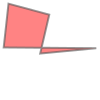

In [13]:
o3d_parcel_corners=pcd_selection.select_by_index([21211, 13975,19867,7066,2739 ])
o3d_parcel_corners=np.array(o3d_parcel_corners.points)[:,:2]
Polygon(o3d_parcel_corners)

In [14]:
pgon = Polygon(o3d_parcel_corners)
print(f"This is the obtained parcel area: {pgon.area} m²")

This is the obtained parcel area: 444.68538564947534 m²


In [15]:
def sort_coordinates(XY):
    cx, cy = XY.mean(0)
    x, y = XY.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(-angles)
    return XY[indices]

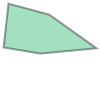

In [16]:
np_sorted_2D_corners=sort_coordinates(o3d_parcel_corners)
pgon = Polygon(np_sorted_2D_corners)
Polygon(np_sorted_2D_corners) 

In [17]:
print(f"This is the parcel area: {pgon.area} m²")

This is the parcel area: 872.4128926074803 m²


## Challenge 3: High and Low POI

In [18]:
print(pcd_selection.get_max_bound())
print(pcd_selection.get_min_bound())

[2.42234016e+05 4.85197955e+05 2.46490002e+01]
[2.42134535e+05 4.85098269e+05 1.09259996e+01]


In [19]:
np_pcd_selection=np.array(pcd_selection.points)
lowest_point_index=np.argmin(np_pcd_selection[:,2])
highest_point_index=np.argmax(np_pcd_selection[:,2])

In [20]:
low_point=pcd_selection.points[lowest_point_index]
high_point=pcd_selection.points[highest_point_index]

o3d.visualization.draw_geometries([pcd_selection])

In [21]:
lp=o3d.geometry.TriangleMesh.create_sphere()
hp=o3d.geometry.TriangleMesh.create_sphere()
lp.translate(np_pcd_selection[lowest_point_index])
hp.translate(np_pcd_selection[highest_point_index])

TriangleMesh with 762 points and 1520 triangles.

In [22]:
lp.compute_vertex_normals()
lp.paint_uniform_color([0.8,0.1,0.1])
hp.compute_vertex_normals()
hp.paint_uniform_color([0.1,0.1,0.8])
o3d.visualization.draw_geometries([pcd_selection,lp,hp])

## Point Cloud Voxelization

Adapting the coloring scheme: RGB

In [23]:
pcd_o3d.colors=o3d.utility.Vector3dVector(np.array(pcd_df[['R','G','B']])/255)
pcd_selection=pcd_o3d.select_by_index(idx)
dist_POI=50
POI=mesh.get_center()
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

Createing the voxel grid and visualizing

In [24]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_selection, voxel_size=2)
o3d.visualization.draw_geometries([voxel_grid])

[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

Adapting the colouring scheme: Black and Red, and the selection with another POI if needed.

In [25]:
colors=np.zeros((len(pcd_df), 3))
colors[pcd_df['Classification'] == 6] = [1, 0, 0]
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
dist_POI=50
POI=mesh.get_center()
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

In [26]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_selection, voxel_size=2)
o3d.visualization.draw_geometries([voxel_grid])

In [27]:
idx_voxels=[v.grid_index for v in voxel_grid.get_voxels()]
color_voxels=[v.color for v in voxel_grid.get_voxels()]
bounds_voxels=[np.min(idx_voxels, axis=0),np.max(idx_voxels, axis=0)]
print(bounds_voxels)

[array([0, 0, 0]), array([50, 50,  7])]


## Challenge 4: Built Coverage

In [28]:
max_voxel={}
max_color={}

In [29]:
for idx, v in enumerate(idx_voxels):
    if (v[0],v[1]) in max_voxel.keys():
        if v[2]>max_voxel[(v[0],v[1])]:
            max_voxel[(v[0],v[1])]=v[2]
            max_color[(v[0],v[1])]=color_voxels[idx]
    else:
        max_voxel[(v[0],v[1])]=v[2]
        max_color[(v[0],v[1])]=color_voxels[idx]

In [30]:
count_building_coverage,count_non_building=0,0
for col in list(max_color.values()):
    if np.all(col==0):
        count_non_building+=1
    else:
        count_building_coverage+=1

In [31]:
print(f"Coverage of Buildings: {count_building_coverage*4} m²")   
print(f"Coverage of the Rest: {count_non_building*4} m²")
print(f"Built Ratio: {(count_building_coverage*4)/(count_building_coverage*4+count_non_building*4)} m²") 

Coverage of Buildings: 3908 m²
Coverage of the Rest: 4192 m²
Built Ratio: 0.48246913580246914 m²


# 5. Data Export

In [32]:
#Exporting the selection
o3d.io.write_point_cloud(result_folder+pc_dataset.split(".")[0]+"_result_filtered_o3d.ply", pcd_selection, write_ascii=False, compressed=False, print_progress=False)

[Open3D WARNING] Write PLY failed: unable to open file: ../DATA/RESULTS/28GN1_08_sampled_result_filtered_o3d.ply


False

In [34]:
#Exporting the Parcel Area
# np.savetxt(result_folder+pc_dataset.split(".")[0]+"_selection.xyz", np.asarray(o3d_parcel_corners),delimiter=';', fmt='%1.9f')